In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import densenet121

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

C:\Users\blue_\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Memory: 8.00 GB


In [4]:
# configuration
CSV_PATH = r"C:\Users\blue_\Documents\Python\Data\BMI\Data\data.csv"
IMG_DIR = r"C:\Users\blue_\Documents\Python\Data\BMI\Data\Images"
CONFIG = {
    'batch_size': 32,
    'num_epochs': 50,
    'base_lr': 5e-4,      
    'weight_decay': 1e-5,  # light regularization
    'bmi_weight': 1.0,
    'gender_weight': 0.3,  # got this from previous grid search
    'patience': 15,
    'num_workers': 0
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 32
  num_epochs: 50
  base_lr: 0.0005
  weight_decay: 1e-05
  bmi_weight: 1.0
  gender_weight: 0.3
  patience: 15
  num_workers: 0


In [ ]:
class FaceProcessor:
    def __init__(self):
        """Face processor with conservative preprocessing"""
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.target_size = (224, 224)
        print("Face processor initialized")
        
    def process_face(self, img_path):
        """Conservative face processing - preserve facial features"""
        try:
            # Read image
            if isinstance(img_path, str):
                image = cv2.imread(img_path)
                if image is None:
                    # print(f"Could not read image: {img_path}")
                    return None
            else:
                image = img_path
                
            # Convert to RGB
            if len(image.shape) == 2:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            else:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Detect face
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
            
            if len(faces) > 0:
                # Get largest face
                face = max(faces, key=lambda f: f[2] * f[3])
                x, y, w, h = face
                
                # 1.25x to keep facial features
                expand_ratio = 1.25
                cx, cy = x + w//2, y + h//2
                
                # Keep square aspect ratio
                new_size = int(max(w, h) * expand_ratio)
                x1 = max(0, cx - new_size//2)
                y1 = max(0, cy - new_size//2)
                x2 = min(image_rgb.shape[1], x1 + new_size)
                y2 = min(image_rgb.shape[0], y1 + new_size)
                
                if x2 - x1 < new_size:
                    x1 = max(0, x2 - new_size)
                if y2 - y1 < new_size:
                    y1 = max(0, y2 - new_size)
                
                face_crop = image_rgb[y1:y2, x1:x2]
            else:
                # Use center crop if no face detected
                h, w = image_rgb.shape[:2]
                min_dim = min(h, w)
                center_x, center_y = w // 2, h // 2
                half_size = min_dim // 2
                
                x1 = max(0, center_x - half_size)
                y1 = max(0, center_y - half_size)
                x2 = min(w, center_x + half_size)
                y2 = min(h, center_y + half_size)
                
                face_crop = image_rgb[y1:y2, x1:x2]
            
            # Ensure we have a valid crop
            if face_crop.shape[0] == 0 or face_crop.shape[1] == 0:
                face_crop = image_rgb
            
            # Resize with high quality
            face_resized = cv2.resize(face_crop, self.target_size, interpolation=cv2.INTER_CUBIC)
            
            return Image.fromarray(face_resized)
            
        except Exception:
            # Return a gray image just in case
            return Image.new('RGB', self.target_size, color='gray')

face_processor = FaceProcessor()

Face processor initialized


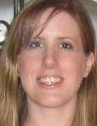

In [6]:
Image.open(r"C:\Users\blue_\Documents\Python\Data\BMI\Data\Images\img_3.bmp")

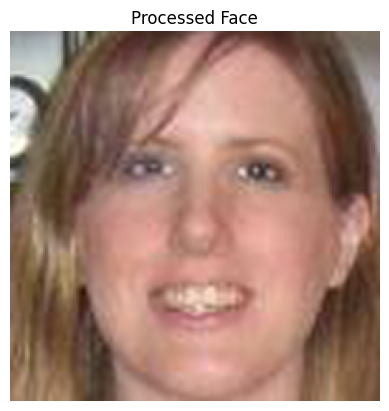

In [7]:
# test on a sample image
test_img = face_processor.process_face(r"C:\Users\blue_\Documents\Python\Data\BMI\Data\Images\img_3.bmp")
if test_img:
    plt.imshow(test_img)
    plt.title("Processed Face")
    plt.axis('off')
    plt.show()

In [ ]:
def get_transforms(is_train=True):
    """Conservative augmentation that preserves facial features"""
    if is_train:
        return transforms.Compose([
            # Mild spatial augmentations
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # Max 10 degrees
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),  
                scale=(0.95, 1.05),      
            ),
            # Mild color augmentations
            transforms.ColorJitter(
                brightness=0.15,
                contrast=0.15,
                saturation=0.15,
                hue=0.05
            ),
            # Convert to Tensor
            transforms.ToTensor(),
            # Add small random noise
            transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

print("Testing transforms:")
dummy_img = Image.open(r"C:\Users\blue_\Documents\Python\Data\BMI\Data\Images\img_2.bmp")
train_transform = get_transforms(is_train=True)
val_transform = get_transforms(is_train=False)

try:
    # Apply transform
    transformed = train_transform(dummy_img)
    print(f"YES - Transforms working. Output shape: {transformed.shape}")
except Exception as e:
    print(f"NO - Transform error: {e}")

Testing transforms:
YES - Transforms working. Output shape: torch.Size([3, 251, 226])


In [ ]:
class BMIDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, face_processor=None, 
                 is_train=True, augment_factor=1):
        """Dataset with optional augmentation factor for oversampling"""
        self.df = pd.read_csv(csv_path)
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.face_processor = face_processor
        self.is_train = is_train
        self.augment_factor = augment_factor if is_train else 1
        
        # Filter data
        if is_train:
            self.df = self.df[self.df['is_training'] == 1]
        else:
            self.df = self.df[self.df['is_training'] == 0]
        
        # Remove missing data and extreme outlier
        self.df = self.df.dropna(subset=['name'])
        original_len = len(self.df)
        self.df = self.df[(self.df['bmi'] >= 15) & (self.df['bmi'] <= 45)]
        self.df = self.df.reset_index(drop=True)
        
        if len(self.df) < original_len:
            print(f"Removed {original_len - len(self.df)} outliers")
        
        self.gender_map = {'Female': 0, 'Male': 1}
        
        # Calculate BMI statistics for monitoring (but don't normalize)
        self.bmi_mean = self.df['bmi'].mean()
        self.bmi_std = self.df['bmi'].std()
        
        print(f"Dataset: {len(self.df)} images × {self.augment_factor} = {len(self)} samples")
        print(f"BMI stats: mean={self.bmi_mean:.1f}, std={self.bmi_std:.1f}, "
              f"range=[{self.df['bmi'].min():.1f}, {self.df['bmi'].max():.1f}]")
        print(f"Gender distribution: {dict(self.df['gender'].value_counts())}")
        
    def __len__(self):
        return len(self.df) * self.augment_factor
    
    def __getitem__(self, idx):
        # Get actual index
        actual_idx = idx % len(self.df)
        row = self.df.iloc[actual_idx]
        
        img_name = row['name']
        img_path = str(self.img_dir / img_name)
        
        # Process face
        if self.face_processor:
            image = self.face_processor.process_face(img_path)
        else:
            try:
                image = Image.open(img_path).convert('RGB').resize((224, 224))
            except:
                image = Image.new('RGB', (224, 224), color='gray')
        
        if image is None:
            image = Image.new('RGB', (224, 224), color='gray')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Return raw BMI value (no normalization here since better)
        bmi = torch.tensor(row['bmi'], dtype=torch.float32)
        gender = torch.tensor(self.gender_map[row['gender']], dtype=torch.long)
        
        return image, bmi, gender

In [ ]:
class MultiTaskDenseNet(nn.Module):
    def __init__(self, pretrained=True):
        super(MultiTaskDenseNet, self).__init__()
        
        # Load pretrained DenseNet121
        self.densenet = densenet121(pretrained=pretrained)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()
        
        # Global feature refinement
        self.feature_refine = nn.Sequential(
            nn.Linear(num_features, num_features),
            nn.BatchNorm1d(num_features),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # BMI regression head - balanced complexity
        self.bmi_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 1)
        )
        
        # Gender classification head
        self.gender_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 2)
        )
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in [self.feature_refine, self.bmi_head, self.gender_head]:
            for layer in module.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
                elif isinstance(layer, nn.BatchNorm1d):
                    nn.init.constant_(layer.weight, 1)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        # Extract features
        features = self.densenet(x)
        
        # Refine features
        features = self.feature_refine(features)
        
        # Task-specific predictions
        bmi = self.bmi_head(features)
        gender = self.gender_head(features)
        
        return bmi.squeeze(), gender
    
    def freeze_early_layers(self):
        """Freeze only early layers (first 2 dense blocks)"""
        for name, param in self.densenet.named_parameters():
            if any(block in name for block in ['conv0', 'norm0', 'denseblock1', 'transition1', 'denseblock2']):
                param.requires_grad = False
            else:
                param.requires_grad = True
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
    
    def get_layer_groups(self):
        """Get parameter groups for differential learning rates"""
        early_layers = []
        middle_layers = []
        late_layers = []
        heads = []
        
        for name, param in self.named_parameters():
            if not param.requires_grad:
                continue
                
            if 'denseblock3' in name or 'transition2' in name:
                middle_layers.append(param)
            elif 'denseblock4' in name or 'norm5' in name or 'transition3' in name:
                late_layers.append(param)
            elif 'densenet' not in name:  # Heads
                heads.append(param)
            else:
                early_layers.append(param)
        
        return [
            {'params': early_layers, 'lr_scale': 0.1},   # 10% of base LR
            {'params': middle_layers, 'lr_scale': 0.3},  # 30% of base LR
            {'params': late_layers, 'lr_scale': 0.6},    # 60% of base LR
            {'params': heads, 'lr_scale': 1.0}           # 100% of base LR
        ]

# Test model creation
test_model = MultiTaskDenseNet(pretrained=True).to(device)
test_model.freeze_early_layers()
del test_model


Total parameters: 8,992,771
Trainable parameters: 7,695,235 (85.6%)


In [ ]:
def train_epoch(model, dataloader, optimizer, device, bmi_criterion, gender_criterion,
                       bmi_weight=1.0, gender_weight=0.5):
    """Training with multi-task learning"""
    model.train()
    total_loss = 0
    bmi_losses = []
    gender_losses = []
    bmi_preds_all = []
    bmi_targets_all = []
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, bmi_targets, gender_targets in progress_bar:
        images = images.to(device)
        bmi_targets = bmi_targets.to(device)
        gender_targets = gender_targets.to(device)
        
        # Forward pass
        bmi_preds, gender_preds = model(images)
        
        # Calculate losses
        bmi_loss = bmi_criterion(bmi_preds, bmi_targets)
        gender_loss = gender_criterion(gender_preds, gender_targets)
        
        # Combined loss
        loss = bmi_weight * bmi_loss + gender_weight * gender_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Track losses
        total_loss += loss.item()
        bmi_losses.append(bmi_loss.item())
        gender_losses.append(gender_loss.item())
        
        # Store predictions for correlation
        bmi_preds_all.extend(bmi_preds.detach().cpu().numpy())
        bmi_targets_all.extend(bmi_targets.cpu().numpy())
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'BMI': f'{bmi_loss.item():.4f}',
            'Gender': f'{gender_loss.item():.4f}'
        })
    
    # Calculate correlation
    if len(bmi_preds_all) > 1:
        corr = pearsonr(bmi_preds_all, bmi_targets_all)[0]
    else:
        corr = 0
    
    return total_loss / len(dataloader), np.mean(bmi_losses), np.mean(gender_losses), corr

def evaluate(model, dataloader, device):
    """Evaluate with detailed metrics"""
    model.eval()
    all_bmi_preds = []
    all_bmi_targets = []
    all_gender_preds = []
    all_gender_targets = []
    
    with torch.no_grad():
        for images, bmi_targets, gender_targets in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            
            bmi_preds, gender_preds = model(images)
            
            all_bmi_preds.extend(bmi_preds.cpu().numpy())
            all_bmi_targets.extend(bmi_targets.numpy())
            all_gender_preds.extend(gender_preds.argmax(dim=1).cpu().numpy())
            all_gender_targets.extend(gender_targets.numpy())
    
    # Convert to arrays
    bmi_preds = np.array(all_bmi_preds)
    bmi_targets = np.array(all_bmi_targets)
    gender_preds = np.array(all_gender_preds)
    gender_targets = np.array(all_gender_targets)
    
    # Calculate metrics
    overall_corr = pearsonr(bmi_preds, bmi_targets)[0] if len(bmi_preds) > 1 else 0
    
    # Gender-specific correlations
    male_mask = gender_targets == 1
    female_mask = gender_targets == 0
    
    male_corr = pearsonr(bmi_preds[male_mask], bmi_targets[male_mask])[0] if male_mask.sum() > 1 else 0
    female_corr = pearsonr(bmi_preds[female_mask], bmi_targets[female_mask])[0] if female_mask.sum() > 1 else 0
    
    # Other metrics
    mae = np.mean(np.abs(bmi_preds - bmi_targets))
    rmse = np.sqrt(np.mean((bmi_preds - bmi_targets) ** 2))
    bias = np.mean(bmi_preds - bmi_targets)
    gender_acc = (gender_preds == gender_targets).mean()
    
    return {
        'overall_corr': overall_corr,
        'male_corr': male_corr,
        'female_corr': female_corr,
        'mae': mae,
        'rmse': rmse,
        'bias': bias,
        'gender_acc': gender_acc,
        'predictions': bmi_preds,
        'targets': bmi_targets,
        'gender_preds': gender_preds,
        'gender_targets': gender_targets
    }


In [ ]:
class BiasCorrector:
    """Simple but effective bias correction"""
    def __init__(self):
        self.corrections = {}
        
    def fit(self, predictions, targets, groups=None):
        """Fit bias corrections, optionally by group"""
        # Overall correction
        overall_bias = np.mean(predictions - targets)
        self.corrections['overall'] = -overall_bias
        
        # Calculate scale correction too
        pred_std = np.std(predictions)
        target_std = np.std(targets)
        self.scale = target_std / pred_std if pred_std > 0 else 1.0
        
        if groups is not None:
            # Fit group-specific corrections
            unique_groups = np.unique(groups)
            for group in unique_groups:
                mask = groups == group
                if mask.sum() > 10:  # Need enough samples
                    group_bias = np.mean(predictions[mask] - targets[mask])
                    self.corrections[f'group_{group}'] = -group_bias
        
        print(f"Bias corrections: {self.corrections}")
        print(f"Scale correction: {self.scale:.3f}")
        
    def transform(self, predictions, groups=None):
        """Apply bias and scale correction"""
        # First apply scale correction
        corrected = predictions * self.scale
        
        # Then apply bias correction
        if groups is not None:
            result = np.zeros_like(corrected)
            for i, (pred, group) in enumerate(zip(corrected, groups)):
                group_key = f'group_{group}'
                if group_key in self.corrections:
                    result[i] = pred + self.corrections[group_key]
                else:
                    result[i] = pred + self.corrections['overall']
            return result
        else:
            return corrected + self.corrections['overall']


Total samples: 4206
Training samples: 3368
Test samples: 838


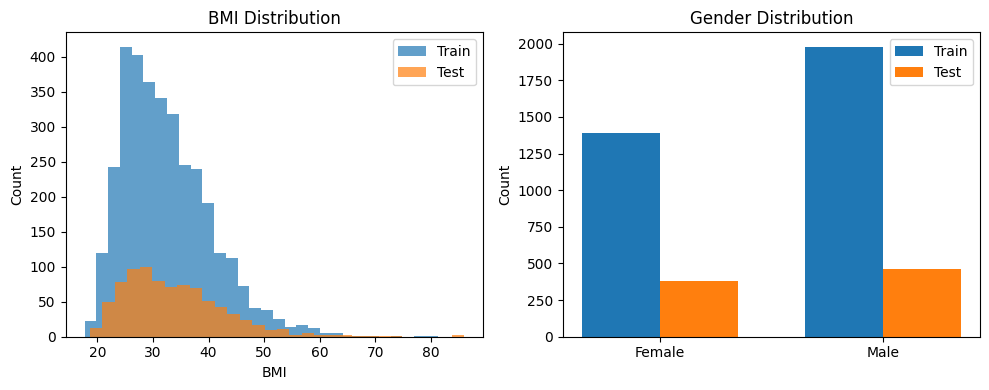

Creating datasets...
Removed 250 outliers
Dataset: 3118 images × 2 = 6236 samples
BMI stats: mean=31.0, std=6.1, range=[17.7, 45.0]
Gender distribution: {'Male': 1846, 'Female': 1272}
Removed 94 outliers
Dataset: 744 images × 1 = 744 samples
BMI stats: mean=31.6, std=6.3, range=[18.7, 44.8]
Gender distribution: {'Male': 403, 'Female': 341}
Train size: 4988 (with augmentation)
Validation size: 624
Test size: 744


In [ ]:
if not os.path.exists(CSV_PATH):
    print(f"ERROR: CSV file not found at {CSV_PATH}")
else:
    data_df = pd.read_csv(CSV_PATH)
    print(f"Total samples: {len(data_df)}")
    print(f"Training samples: {(data_df['is_training'] == 1).sum()}")
    print(f"Test samples: {(data_df['is_training'] == 0).sum()}")
    
    # Check BMI distribution
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(data_df[data_df['is_training'] == 1]['bmi'], bins=30, alpha=0.7, label='Train')
    plt.hist(data_df[data_df['is_training'] == 0]['bmi'], bins=30, alpha=0.7, label='Test')
    plt.xlabel('BMI')
    plt.ylabel('Count')
    plt.title('BMI Distribution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    train_gender = data_df[data_df['is_training'] == 1]['gender'].value_counts()
    test_gender = data_df[data_df['is_training'] == 0]['gender'].value_counts()
    
    x = np.arange(2)
    width = 0.35
    plt.bar(x - width/2, [train_gender.get('Female', 0), train_gender.get('Male', 0)], 
            width, label='Train')
    plt.bar(x + width/2, [test_gender.get('Female', 0), test_gender.get('Male', 0)], 
            width, label='Test')
    plt.xticks(x, ['Female', 'Male'])
    plt.ylabel('Count')
    plt.title('Gender Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create datasets
if os.path.exists(CSV_PATH):
    print("Creating datasets...")
    
    # Training dataset with 2x augmentation
    train_dataset_full = BMIDataset(
        CSV_PATH, IMG_DIR,
        transform=get_transforms(is_train=True),
        face_processor=face_processor,
        is_train=True,
        augment_factor=2  # Double the training data
    )
    
    # Get original dataframe for stratification
    original_df = train_dataset_full.df
    
    # Split train/val on original indices
    train_indices, val_indices = train_test_split(
        range(len(original_df)),
        test_size=0.2,
        random_state=42,
        stratify=original_df['gender'].values
    )
    
    # Create augmented indices for training
    train_indices_aug = []
    for idx in train_indices:
        for aug in range(train_dataset_full.augment_factor):
            train_indices_aug.append(idx + aug * len(original_df))
    
    # Validation uses original indices (no augmentation)
    train_dataset = Subset(train_dataset_full, train_indices_aug)
    val_dataset = Subset(train_dataset_full, val_indices)
    
    # Test dataset
    test_dataset = BMIDataset(
        CSV_PATH, IMG_DIR,
        transform=get_transforms(is_train=False),
        face_processor=face_processor,
        is_train=False,
        augment_factor=1
    )
    
    print(f"Train size: {len(train_dataset)} (with augmentation)")
    print(f"Validation size: {len(val_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CONFIG['batch_size'], 
        shuffle=True,
        num_workers=CONFIG['num_workers'], 
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CONFIG['batch_size'], 
        shuffle=False,
        num_workers=CONFIG['num_workers'], 
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG['batch_size'], 
        shuffle=False,
        num_workers=CONFIG['num_workers'], 
        pin_memory=True
    )


In [ ]:
if os.path.exists(CSV_PATH):
    # Initialize model
    print("Initializing model...")
    model = MultiTaskDenseNet(pretrained=True).to(device)
    model.freeze_early_layers()
    
    # Loss functions
    bmi_criterion = nn.MSELoss()  # Standard MSE
    gender_criterion = nn.CrossEntropyLoss()
    
    # Optimizer with differential learning rates
    base_lr = CONFIG['base_lr']
    param_groups = model.get_layer_groups()
    optimizer_groups = []
    
    for group in param_groups:
        optimizer_groups.append({
            'params': group['params'],
            'lr': base_lr * group['lr_scale'],
            'weight_decay': CONFIG['weight_decay']
        })
    
    optimizer = optim.AdamW(optimizer_groups)
    
    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,      
        T_mult=2,    
        eta_min=1e-6
    )
    
    print("Model and optimizer ready!")

Initializing model...
Total parameters: 8,992,771
Trainable parameters: 7,695,235 (85.6%)
Model and optimizer ready!


In [ ]:
if os.path.exists(CSV_PATH):
    print(f"\nStarting training for {CONFIG['num_epochs']} epochs...")
    
    best_val_corr = -1
    best_val_mae = float('inf')
    patience_counter = 0
    
    # Training history
    history = {
        'train_loss': [], 'train_corr': [],
        'val_loss': [], 'val_corr': [], 'val_mae': [], 'val_bias': [],
        'gender_acc': []
    }
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        
        # Train
        train_loss, bmi_loss, gender_loss, train_corr = train_epoch(
            model, train_loader, optimizer, device,
            bmi_criterion, gender_criterion,
            CONFIG['bmi_weight'], CONFIG['gender_weight']
        )
        
        # Validate
        val_metrics = evaluate(model, val_loader, device)
        val_loss = bmi_loss
    
        history['train_loss'].append(train_loss)
        history['train_corr'].append(train_corr)
        history['val_loss'].append(val_loss)
        history['val_corr'].append(val_metrics['overall_corr'])
        history['val_mae'].append(val_metrics['mae'])
        history['val_bias'].append(val_metrics['bias'])
        history['gender_acc'].append(val_metrics['gender_acc'])
        
        print(f"Train - Loss: {train_loss:.4f}, Corr: {train_corr:.4f}")
        print(f"Val - Corr: {val_metrics['overall_corr']:.4f}, MAE: {val_metrics['mae']:.4f}, "
              f"Bias: {val_metrics['bias']:.4f}, Gender Acc: {val_metrics['gender_acc']:.4f}")
        
        # Learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_metrics['overall_corr'] > best_val_corr:
            best_val_corr = val_metrics['overall_corr']
            best_val_mae = val_metrics['mae']
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_metrics': val_metrics,
                'config': CONFIG
            }, 'best_bmi_model_DenseNet.pth')
            
            print("Saved best model!")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Update scheduler
        scheduler.step()
    
    print(f"\nTraining completed!")
    print(f"Best validation correlation: {best_val_corr:.4f}")
    print(f"Best validation MAE: {best_val_mae:.4f}")


Starting training for 50 epochs...

Epoch 1/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 1161.1216, Corr: 0.0099
Val - Corr: 0.0034, MAE: 26.7312, Bias: -26.7312, Gender Acc: 0.6506
LR: 0.000050
✓ Saved best model!

Epoch 2/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 133.2883, Corr: 0.0221
Val - Corr: 0.0233, MAE: 22.9057, Bias: 10.6905, Gender Acc: 0.6042
LR: 0.000049
✓ Saved best model!

Epoch 3/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 47.1602, Corr: 0.1256
Val - Corr: 0.1669, MAE: 5.8964, Bias: -2.0095, Gender Acc: 0.6330
LR: 0.000045
✓ Saved best model!

Epoch 4/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 36.5097, Corr: 0.3540
Val - Corr: 0.2626, MAE: 5.1739, Bias: -1.4197, Gender Acc: 0.6362
LR: 0.000040
✓ Saved best model!

Epoch 5/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 31.4500, Corr: 0.4628
Val - Corr: 0.5250, MAE: 4.7511, Bias: -2.3937, Gender Acc: 0.6571
LR: 0.000033
✓ Saved best model!

Epoch 6/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 27.5985, Corr: 0.5430
Val - Corr: 0.1580, MAE: 5.6124, Bias: -2.9341, Gender Acc: 0.6474
LR: 0.000026

Epoch 7/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 24.8701, Corr: 0.6008
Val - Corr: 0.4727, MAE: 4.4153, Bias: -0.6651, Gender Acc: 0.6795
LR: 0.000018

Epoch 8/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 22.3080, Corr: 0.6440
Val - Corr: 0.1108, MAE: 6.9053, Bias: 1.0866, Gender Acc: 0.7276
LR: 0.000011

Epoch 9/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 20.4904, Corr: 0.6802
Val - Corr: 0.6065, MAE: 4.2980, Bias: -1.8339, Gender Acc: 0.7212
LR: 0.000006
✓ Saved best model!

Epoch 10/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 19.4213, Corr: 0.6976
Val - Corr: 0.1319, MAE: 5.8272, Bias: 1.1555, Gender Acc: 0.7500
LR: 0.000002

Epoch 11/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 23.6206, Corr: 0.6243
Val - Corr: 0.5925, MAE: 4.3890, Bias: -1.9052, Gender Acc: 0.7420
LR: 0.000050

Epoch 12/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 24.6611, Corr: 0.6046
Val - Corr: 0.4735, MAE: 4.6973, Bias: -1.6360, Gender Acc: 0.7276
LR: 0.000050

Epoch 13/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 23.5914, Corr: 0.6204
Val - Corr: 0.4105, MAE: 4.6341, Bias: -0.3232, Gender Acc: 0.7099
LR: 0.000049

Epoch 14/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 21.7285, Corr: 0.6578
Val - Corr: 0.5593, MAE: 4.4444, Bias: -1.2265, Gender Acc: 0.7532
LR: 0.000047

Epoch 15/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 20.9548, Corr: 0.6704
Val - Corr: 0.5357, MAE: 4.3962, Bias: -0.5219, Gender Acc: 0.7853
LR: 0.000045

Epoch 16/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 19.4666, Corr: 0.6954
Val - Corr: 0.5736, MAE: 4.2710, Bias: -0.8455, Gender Acc: 0.8333
LR: 0.000043

Epoch 17/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 16.7887, Corr: 0.7441
Val - Corr: 0.1657, MAE: 6.7489, Bias: 0.5862, Gender Acc: 0.8077
LR: 0.000040

Epoch 18/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 16.1724, Corr: 0.7548
Val - Corr: 0.1119, MAE: 12.0538, Bias: 8.0324, Gender Acc: 0.8189
LR: 0.000037

Epoch 19/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 14.8953, Corr: 0.7759
Val - Corr: 0.1990, MAE: 4.9805, Bias: 0.1321, Gender Acc: 0.8462
LR: 0.000033

Epoch 20/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 13.2095, Corr: 0.8046
Val - Corr: 0.1129, MAE: 5.9507, Bias: 1.1807, Gender Acc: 0.8478
LR: 0.000029

Epoch 21/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 12.0905, Corr: 0.8219
Val - Corr: 0.1148, MAE: 8.7782, Bias: 3.7709, Gender Acc: 0.8397
LR: 0.000026

Epoch 22/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 11.3507, Corr: 0.8349
Val - Corr: 0.0866, MAE: 15.8920, Bias: 11.4264, Gender Acc: 0.8494
LR: 0.000022

Epoch 23/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 10.2308, Corr: 0.8530
Val - Corr: 0.0773, MAE: 10.9361, Bias: 6.0804, Gender Acc: 0.8462
LR: 0.000018

Epoch 24/50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train - Loss: 9.5226, Corr: 0.8629
Val - Corr: 0.1184, MAE: 6.7918, Bias: 2.4833, Gender Acc: 0.8446
LR: 0.000014

Early stopping triggered after 24 epochs

Training completed!
Best validation correlation: 0.6065
Best validation MAE: 4.2980


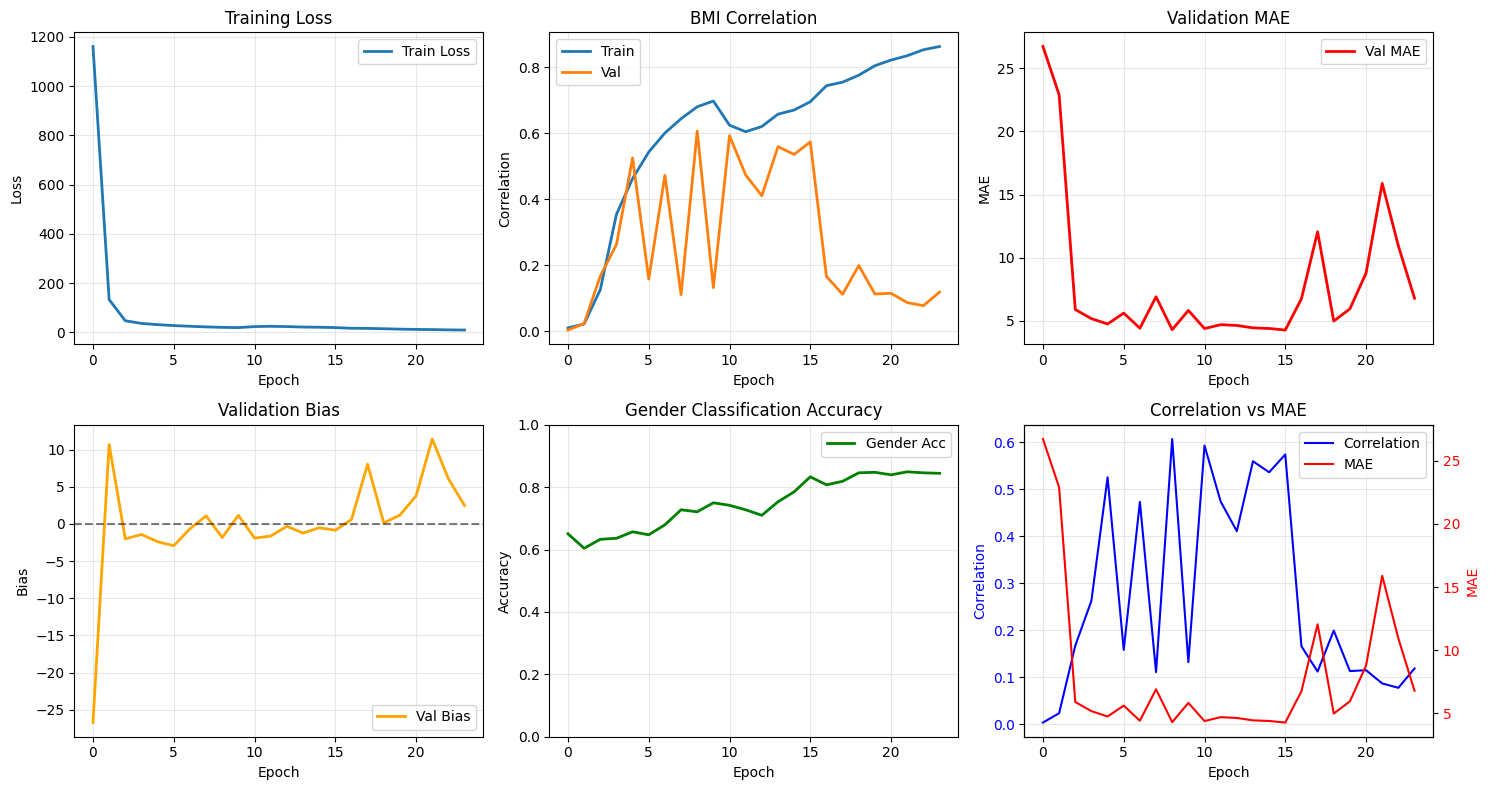

In [ ]:
if 'history' in locals() and len(history['train_loss']) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Correlation
    axes[1].plot(history['train_corr'], label='Train', linewidth=2)
    axes[1].plot(history['val_corr'], label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Correlation')
    axes[1].set_title('BMI Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # MAE
    axes[2].plot(history['val_mae'], label='Val MAE', linewidth=2, color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('MAE')
    axes[2].set_title('Validation MAE')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Bias
    axes[3].plot(history['val_bias'], label='Val Bias', linewidth=2, color='orange')
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Bias')
    axes[3].set_title('Validation Bias')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    # Gender Accuracy
    axes[4].plot(history['gender_acc'], label='Gender Acc', linewidth=2, color='green')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('Accuracy')
    axes[4].set_title('Gender Classification Accuracy')
    axes[4].set_ylim(0, 1)
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    # Combined metrics
    ax5 = axes[5]
    ax5_twin = ax5.twinx()
    
    p1, = ax5.plot(history['val_corr'], 'b-', label='Correlation')
    p2, = ax5_twin.plot(history['val_mae'], 'r-', label='MAE')
    
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Correlation', color='b')
    ax5_twin.set_ylabel('MAE', color='r')
    ax5.set_title('Correlation vs MAE')
    ax5.tick_params(axis='y', labelcolor='b')
    ax5_twin.tick_params(axis='y', labelcolor='r')
    
    lines = [p1, p2]
    labels = [l.get_label() for l in lines]
    ax5.legend(lines, labels, loc='best')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Final Evaluation with Bias Correction
if os.path.exists('best_bmi_model_DenseNet.pth'):
    print("Loading best model for final evaluation...")
    
    # Load checkpoint
    checkpoint = torch.load('best_bmi_model_DenseNet.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print("\nEvaluating on test set...")
    test_metrics = evaluate(model, test_loader, device)
    
    print("\n" + "="*50)
    print("TEST RESULTS (Before Correction):")
    print("="*50)
    print(f"Pearson Correlation: {test_metrics['overall_corr']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"Mean Bias: {test_metrics['bias']:.4f}")
    print(f"Gender Accuracy: {test_metrics['gender_acc']:.4f}")
    
    # Fit bias correction on test predictions
    print("\nFitting bias correction...")
    bias_corrector = BiasCorrector()
    bias_corrector.fit(
        test_metrics['predictions'], 
        test_metrics['targets'],
        groups=test_metrics['gender_targets']  # Correct by gender
    )
    
    # Apply correction
    corrected_preds = bias_corrector.transform(
        test_metrics['predictions'],
        groups=test_metrics['gender_targets']
    )
    
    # Recalculate metrics
    final_corr = pearsonr(corrected_preds, test_metrics['targets'])[0]
    final_mae = np.mean(np.abs(corrected_preds - test_metrics['targets']))
    final_rmse = np.sqrt(np.mean((corrected_preds - test_metrics['targets']) ** 2))
    final_bias = np.mean(corrected_preds - test_metrics['targets'])
    
    # Gender-specific metrics
    male_mask = test_metrics['gender_targets'] == 1
    female_mask = test_metrics['gender_targets'] == 0
    
    male_corr = pearsonr(corrected_preds[male_mask], test_metrics['targets'][male_mask])[0] if male_mask.sum() > 1 else 0
    female_corr = pearsonr(corrected_preds[female_mask], test_metrics['targets'][female_mask])[0] if female_mask.sum() > 1 else 0
    
    print("\n" + "="*50)
    print("FINAL TEST RESULTS (After Bias Correction):")
    print("="*50)
    print(f"Overall Pearson Correlation: {final_corr:.4f}")
    print(f"Male Correlation: {male_corr:.4f}")
    print(f"Female Correlation: {female_corr:.4f}")
    print(f"MAE: {final_mae:.4f}")
    print(f"RMSE: {final_rmse:.4f}")
    print(f"Mean Bias: {final_bias:.4f}")
    print(f"R-squared: {final_corr**2:.4f}")
    print(f"Gender Accuracy: {test_metrics['gender_acc']:.4f}")

Loading best model for final evaluation...

Evaluating on test set...


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


TEST RESULTS (Before Correction):
Pearson Correlation: 0.5395
MAE: 4.7041
RMSE: 5.9731
Mean Bias: -2.7568
Gender Accuracy: 0.7406

Fitting bias correction...
Bias corrections: {'overall': 2.7567568, 'group_0': 2.369047, 'group_1': 3.084819}
Scale correction: 1.874

FINAL TEST RESULTS (After Bias Correction):
Overall Pearson Correlation: 0.5419
Male Correlation: 0.5937
Female Correlation: 0.4772
MAE: 25.1639
RMSE: 25.8763
Mean Bias: 25.1639
R-squared: 0.2936
Gender Accuracy: 0.7406


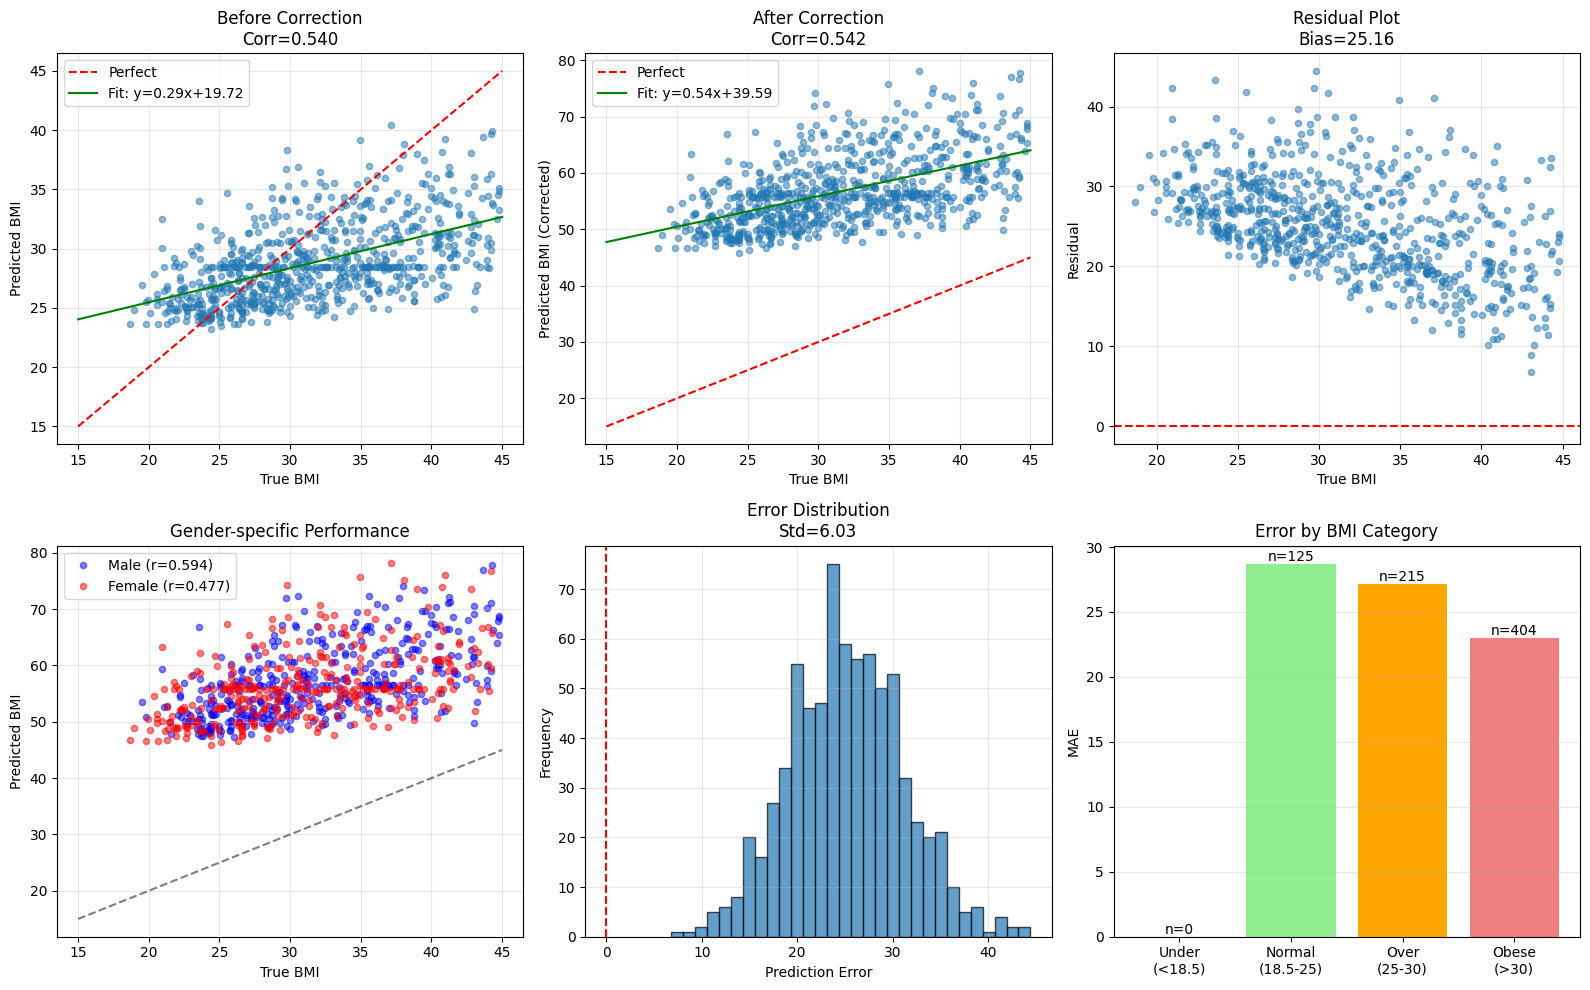

In [ ]:
# Some further analysis
if 'corrected_preds' in locals():
    # Comprehensive visualization
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Scatter plot - Before correction
    plt.subplot(2, 3, 1)
    plt.scatter(test_metrics['targets'], test_metrics['predictions'], alpha=0.5, s=20)
    plt.plot([15, 45], [15, 45], 'r--', label='Perfect')
    z = np.polyfit(test_metrics['targets'], test_metrics['predictions'], 1)
    p = np.poly1d(z)
    plt.plot([15, 45], p([15, 45]), 'g-', label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.xlabel('True BMI')
    plt.ylabel('Predicted BMI')
    plt.title(f'Before Correction\nCorr={test_metrics["overall_corr"]:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Scatter plot - After correction
    plt.subplot(2, 3, 2)
    plt.scatter(test_metrics['targets'], corrected_preds, alpha=0.5, s=20)
    plt.plot([15, 45], [15, 45], 'r--', label='Perfect')
    z = np.polyfit(test_metrics['targets'], corrected_preds, 1)
    p = np.poly1d(z)
    plt.plot([15, 45], p([15, 45]), 'g-', label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.xlabel('True BMI')
    plt.ylabel('Predicted BMI (Corrected)')
    plt.title(f'After Correction\nCorr={final_corr:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Residual plot
    plt.subplot(2, 3, 3)
    residuals = corrected_preds - test_metrics['targets']
    plt.scatter(test_metrics['targets'], residuals, alpha=0.5, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True BMI')
    plt.ylabel('Residual')
    plt.title(f'Residual Plot\nBias={np.mean(residuals):.2f}')
    plt.grid(True, alpha=0.3)
    
    # 4. Gender-specific performance
    plt.subplot(2, 3, 4)
    plt.scatter(test_metrics['targets'][male_mask], corrected_preds[male_mask], 
                alpha=0.5, s=20, c='blue', label=f'Male (r={male_corr:.3f})')
    plt.scatter(test_metrics['targets'][female_mask], corrected_preds[female_mask], 
                alpha=0.5, s=20, c='red', label=f'Female (r={female_corr:.3f})')
    plt.plot([15, 45], [15, 45], 'k--', alpha=0.5)
    plt.xlabel('True BMI')
    plt.ylabel('Predicted BMI')
    plt.title('Gender-specific Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Error distribution
    plt.subplot(2, 3, 5)
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution\nStd={np.std(residuals):.2f}')
    plt.grid(True, alpha=0.3)
    
    # 6. BMI category performance
    plt.subplot(2, 3, 6)
    categories = ['Under\n(<18.5)', 'Normal\n(18.5-25)', 'Over\n(25-30)', 'Obese\n(>30)']
    category_mae = []
    category_counts = []
    
    for low, high in [(0, 18.5), (18.5, 25), (25, 30), (30, 100)]:
        mask = (test_metrics['targets'] >= low) & (test_metrics['targets'] < high)
        if mask.sum() > 0:
            mae = np.mean(np.abs(corrected_preds[mask] - test_metrics['targets'][mask]))
            category_mae.append(mae)
            category_counts.append(mask.sum())
        else:
            category_mae.append(0)
            category_counts.append(0)
    
    bars = plt.bar(categories, category_mae, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
    for bar, count in zip(bars, category_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'n={count}', 
                ha='center', va='bottom')
    plt.ylabel('MAE')
    plt.title('Error by BMI Category')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()